In [1]:
%load_ext autoreload
%autoreload 2

import sys
if '..' not in sys.path:
    sys.path.append('..')


import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import matplotlib
import re
import multiprocessing

from lib.mobilitysim import MobilitySimulator
from lib.dynamics import DiseaseModel
from lib.inference import * 
from bayes_opt import BayesianOptimization
from lib.parallel import *
from lib.distributions import CovidDistributions
from lib.plot import Plotter
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, 
    BetaMultiplierMeasure, 
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForKGroups,
    SocialDistancingByAgeMeasure,
    SocialDistancingForPositiveMeasure, 
    ComplianceForAllMeasure,
    Interval,
    ComplianceForEssentialWorkers)

from lib.mobilitysim import MobilitySimulator
from lib.town_data import generate_population, generate_sites, compute_distances
from lib.town_maps import MapIllustrator


def save_summary(summary, filename):
    with open('summaries/' + filename, 'wb') as fp:
        pickle.dump(summary, fp)
    
def load_summary(filename):
    with open('summaries/' + filename, 'rb') as fp:
        summary = pickle.load(fp)
    return summary


## Type 3: supermarket

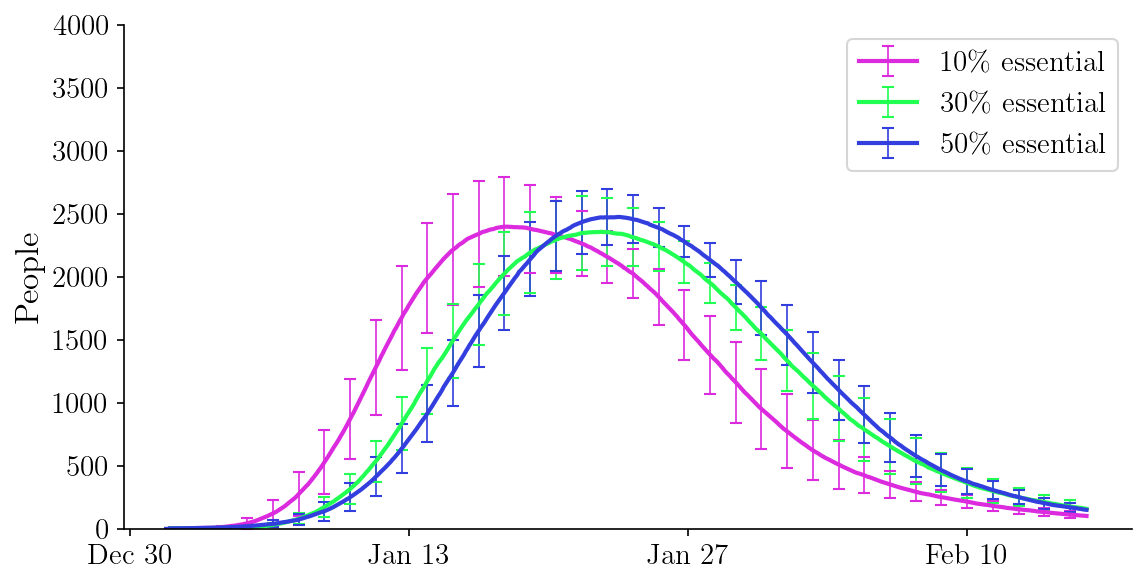

In [55]:
# total population: 4254 , sites: 37
# essential: 430 , non_essential: 3824 , propotion: 0.10108133521391631
# essential proortion per age group: [0.         0.         0.11038961 0.09505703 0.14155529 0.15209581
#  0.03079179 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 3
# work_site: [24, 33, 1, 19, 27, 7, 8, 34, 11, 6, 10, 32, 29, 3, 2] 15
# number of workers at work site: [27, 29, 20, 26, 36, 31, 33, 28, 30, 29, 28, 28, 30, 30, 25] 430
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 3.6, 5]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 0.64, 5]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_prop[0.1,0.3,0.5]sf_one-comp_essential-type3_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['10\% essential','30\% essential','50\% essential']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

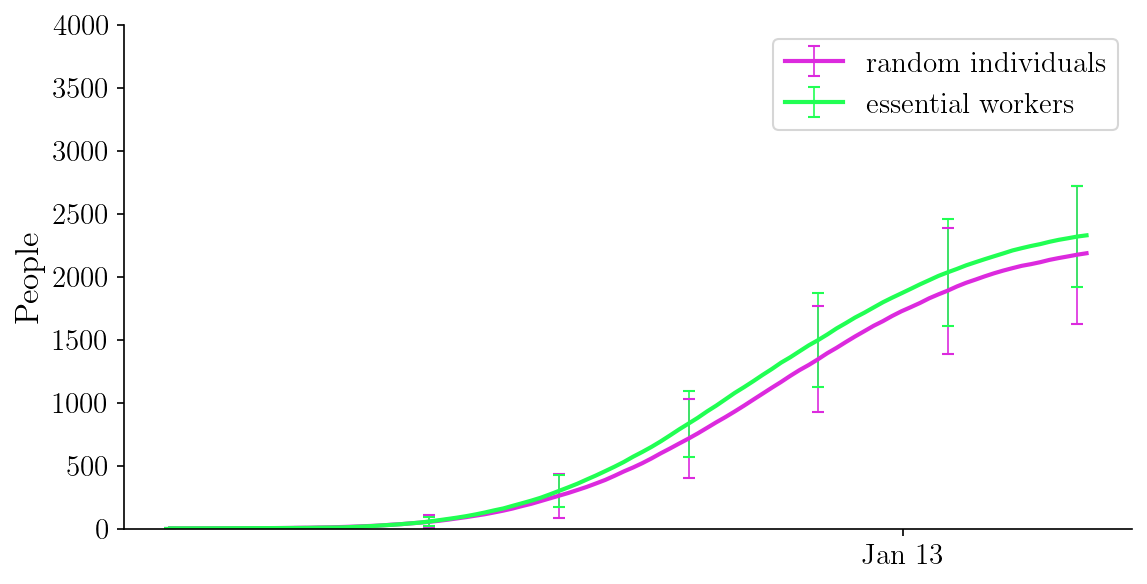

In [25]:
# total population: 4254 , sites: 37
# essential: 430 , non_essential: 3824 , propotion: 0.10108133521391631
# essential proortion per age group: [0.         0.         0.11038961 0.09505703 0.14155529 0.15209581
#  0.03079179 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 3
# work_site: [24, 33, 1, 19, 27, 7, 8, 34, 11, 6, 10, 32, 29, 3, 2] 15
# number of workers at work site: [27, 29, 20, 26, 36, 31, 33, 28, 30, 29, 28, 28, 30, 30, 25] 430
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 3.6, 5]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 0.64, 5]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_sf_one-comp_essential-type3_prop0.1_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=100, 
    ymax=4000, errorevery=14)

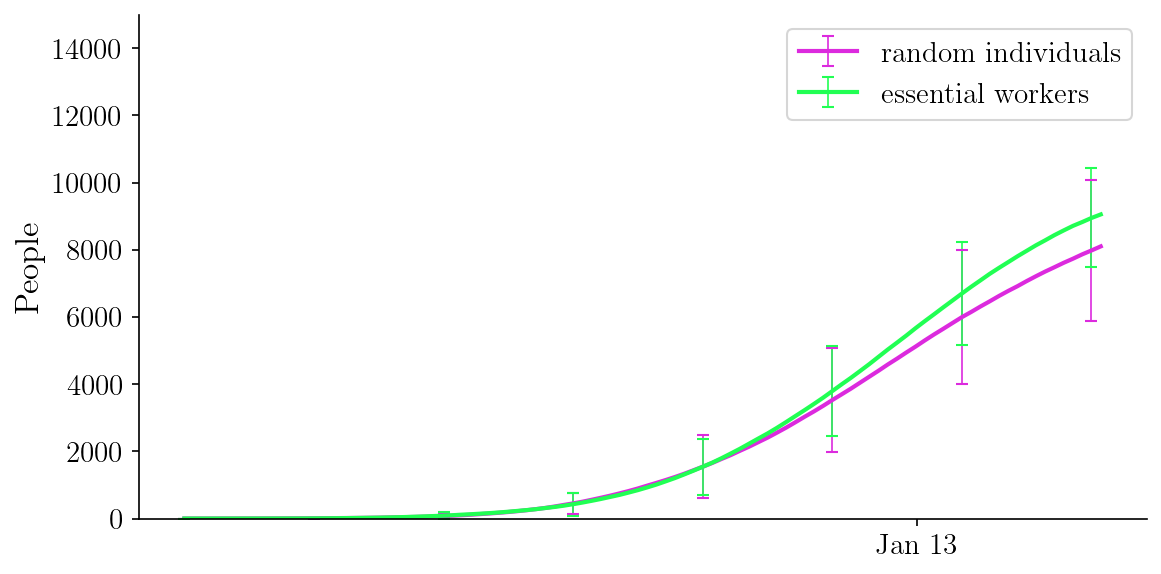

In [35]:
# total population: 17008 , sites: 151
# essential: 1729 , non_essential: 15279 , propotion: 0.10165804327375352
# essential proortion per age group: [0.         0.         0.11038961 0.09705043 0.14198937 0.15264891
#  0.03113553 0.        ]
# Population (by Age):  [774, 1184, 616, 1051, 6585, 3341, 2730, 724]
# Sites by type:  [9, 9, 74, 59]
# essential type: 3
# work_site: [51, 136, 126, 33, 10, 8, 27, 125, 37, 119, 133, 85, 19, 24, 86, 73, 106, 74, 6, 29, 66, 80, 
#             111, 34, 93, 44, 68, 61, 139, 103, 69, 3, 114, 149, 117, 11, 7, 42, 75, 49, 90, 72, 87, 138, 
#             100, 79, 50, 120, 113, 32, 91, 1, 54, 53, 145, 112, 2, 52, 115] 59
# number of workers at work site: [34, 29, 30, 31, 40, 22, 22, 26, 24, 37, 27, 33, 34, 22, 44, 36, 31, 27, 
#                                  32, 19, 28, 30, 35, 34, 19, 23, 27, 27, 38, 33, 28, 33, 20, 34, 33, 21, 
#                                  34, 26, 31, 26, 25, 34, 32, 27, 37, 30, 31, 28, 34, 37, 22, 34, 33, 20, 
#                                  24, 25, 24, 21, 31] 1729
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 3.6, 5]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 0.64, 5]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_sf_one-comp_essential-type3_prop0.1_ds50.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=100, 
    ymax=15000, errorevery=14)

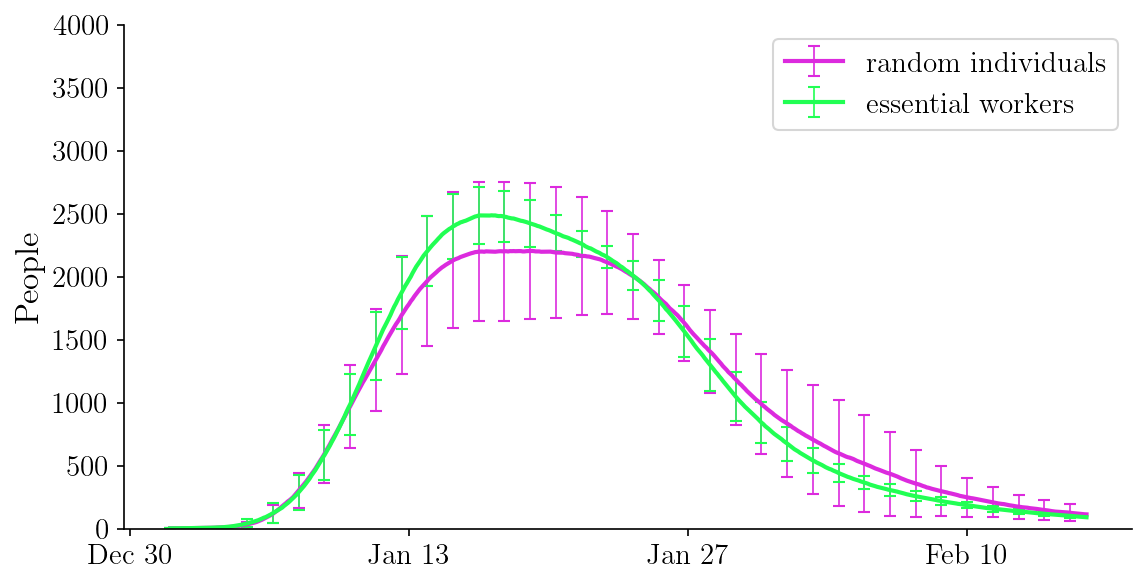

In [39]:
# total population: 4254 , sites: 37
# essential: 430 , non_essential: 3824 , propotion: 0.10108133521391631
# essential proortion per age group: [0.         0.         0.11038961 0.09505703 0.14155529 0.15209581
#  0.03079179 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 3
# work_site: [24, 33, 1, 19, 27, 7, 8, 34, 11, 6, 10, 32, 29, 3, 2] 15
# number of workers at work site: [27, 29, 20, 26, 36, 31, 33, 28, 30, 29, 28, 28, 30, 30, 25] 430
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 3.6, 5]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 0.64, 5]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_sf_one-comp_essential-type3_prop0.1_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

#### Town generator on Local computer

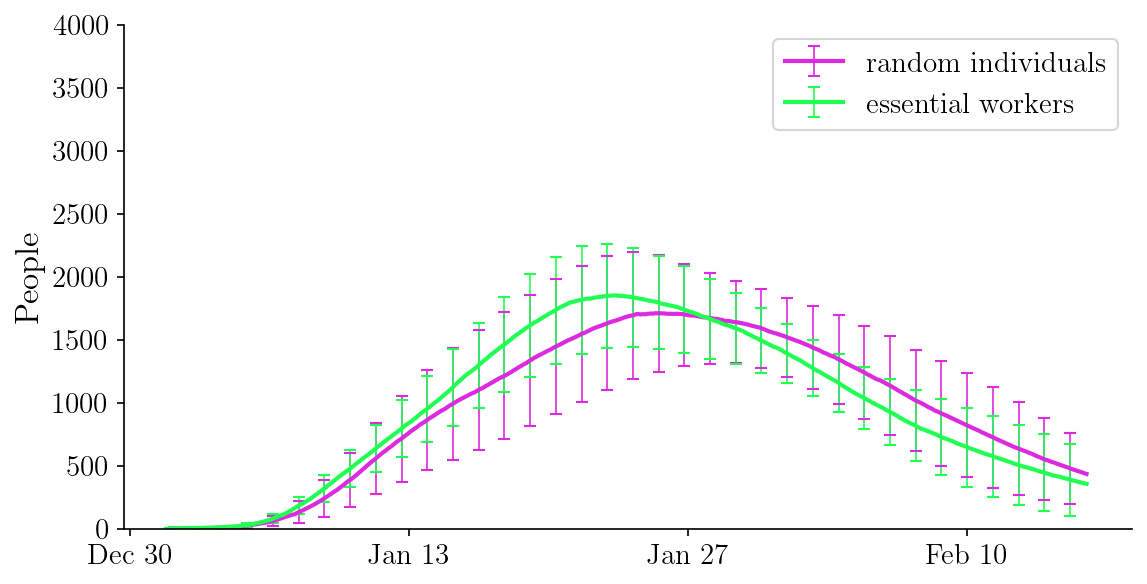

In [5]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181] 4251
# Sites by type:  [2, 20, 12, 3]
# essential type: 3
# work_site: [1, 33, 10] 3
# number of workers at work site: [730, 721, 726] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 3.6, 5]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 0.64, 5]
#    beta household: 0, beta elsewhere: 0.3                 edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats40_sf_one-comp_essential-type3_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6['basic']
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

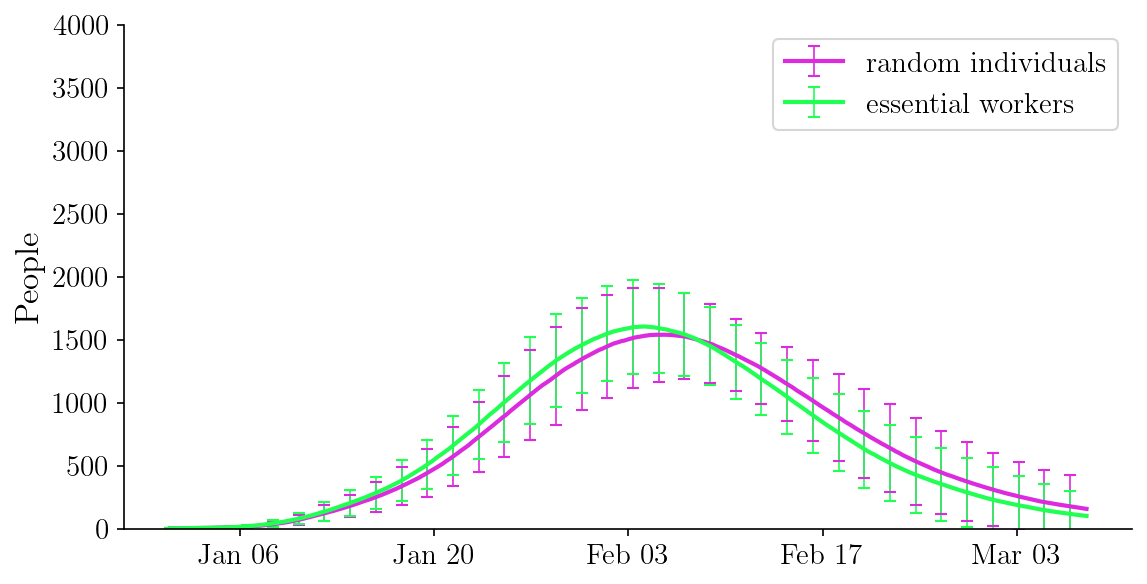

In [8]:
# total population: 4254 , sites: 37
# essential: 430 , non_essential: 3824 , propotion: 0.10108133521391631
# essential proortion per age group: [0.         0.         0.11038961 0.09505703 0.14155529 0.15209581
#  0.03079179 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181] 4251
# Sites by type:  [2, 20, 12, 3]
# essential type: 3
# work_site: [10, 33, 1] 3
# number of workers at work site: [144, 151, 135] 430
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 3.6, 5]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 0.64, 5]
#    beta household: 0, beta elsewhere: 0.3                 edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats40_sf_one-comp_essential-type3_prop0.1_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6['basic']
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

## Type 2: social place

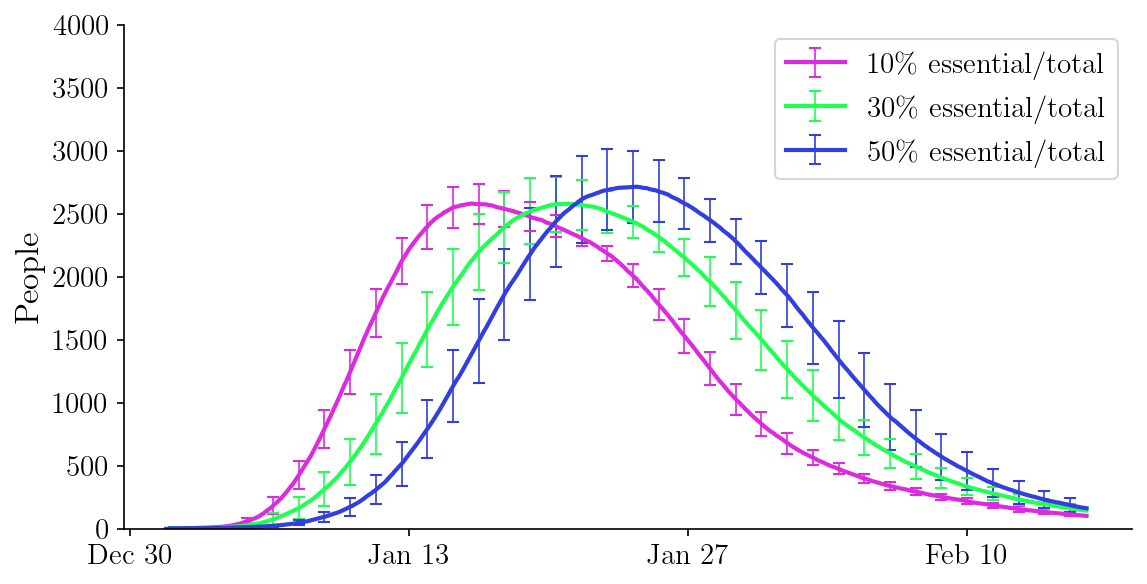

In [78]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [9, 28] 2
# number of workers at work site: [1104, 1073] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 5, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 5, 0.4]
#          100% essetnail comply                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_prop[0.1,0.3,0.5]sf_one-comp_essential-type2_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['10\% essential/total','30\% essential/total','50\% essential/total']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

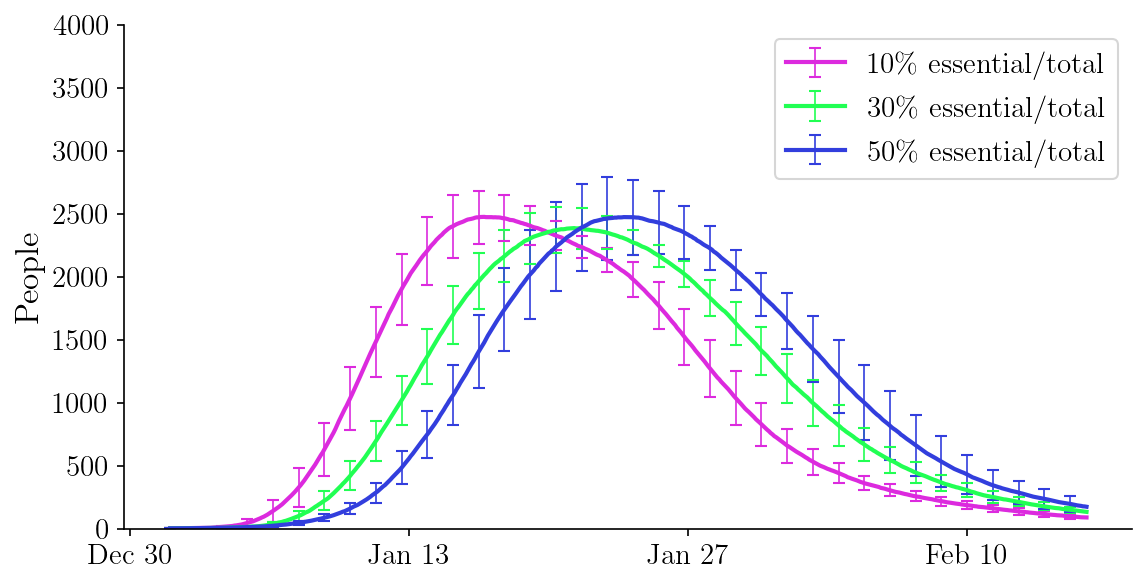

In [86]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [9, 28] 2
# number of workers at work site: [1104, 1073] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 5, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 5, 0.4]
#     100% random comply                                edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[0.5121147965184663]_repeats10_prop[0.1,0.3,0.5]_onlyall_sf_one-comp_essential-type3_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['10\% essential/total','30\% essential/total','50\% essential/total']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

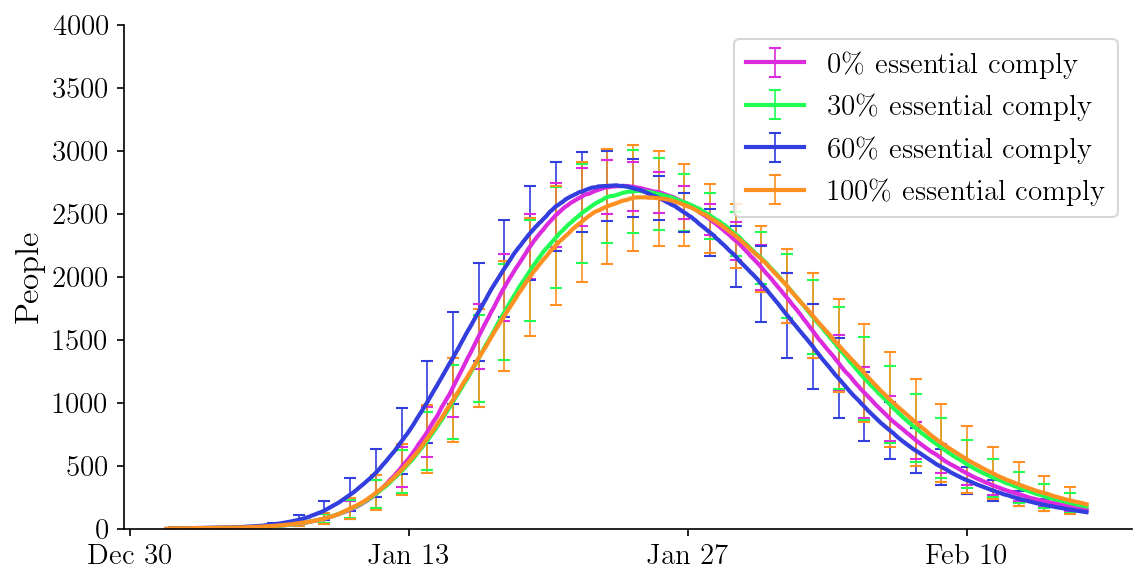

In [81]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [9, 28] 2
# number of workers at work site: [1104, 1073] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 5, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 5, 0.4]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[0.0,0.3,0.6,1.0]_repeats10_onlyessen_sf_one-comp_essential-type2_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['0\% essential comply','30\% essential comply','60\% essential comply','100\% essential comply']
summaries_ = summaries_SD_6['basic']
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

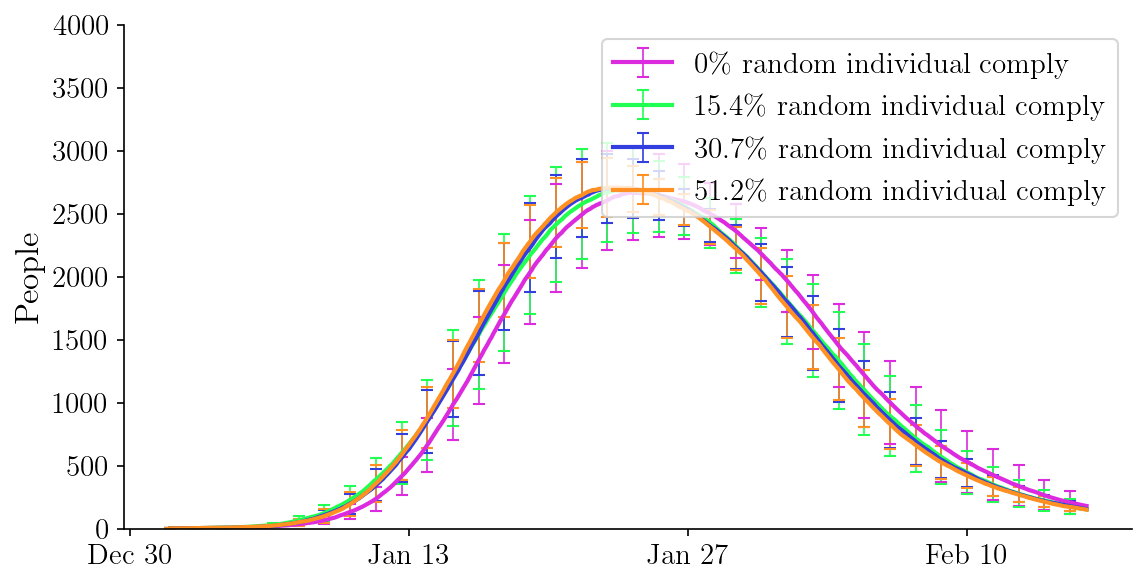

In [82]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [9, 28] 2
# number of workers at work site: [1104, 1073] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 5, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 5, 0.4]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[0.0,0.154,0.307,0.512]_repeats10_onlyall_sf_one-comp_essential-type2_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['0\% random individual comply','15.4\% random individual comply','30.7\% random individual comply','51.2\% random individual comply']
summaries_ = summaries_SD_6['basic']
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)



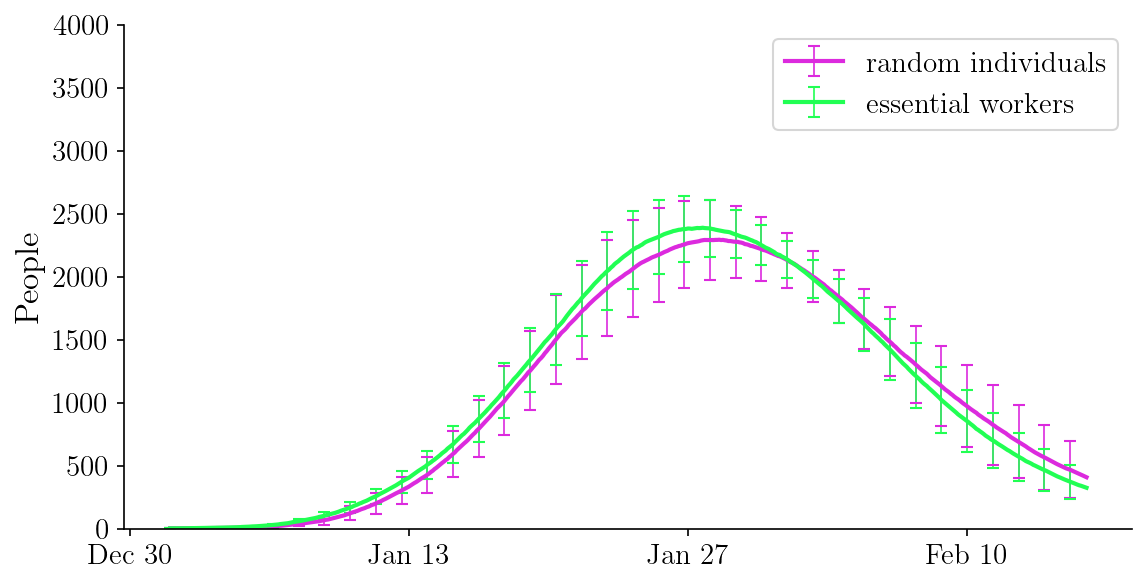

In [90]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 2
# work_site: [13, 30, 18, 14, 21, 0, 35, 16, 17, 26, 25, 22, 12, 15, 23, 4, 20] 17
# number of workers at work site: [141, 117, 151, 99, 141, 128, 135, 120, 127, 135, 124, 114, 120, 140, 124, 151, 110] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 5, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 5, 0.4]
#                                                           edu, office, social, supermarket
# beta household 0, beta else 0.4


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_sf_one-comp_essential-type2_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6['basic']
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

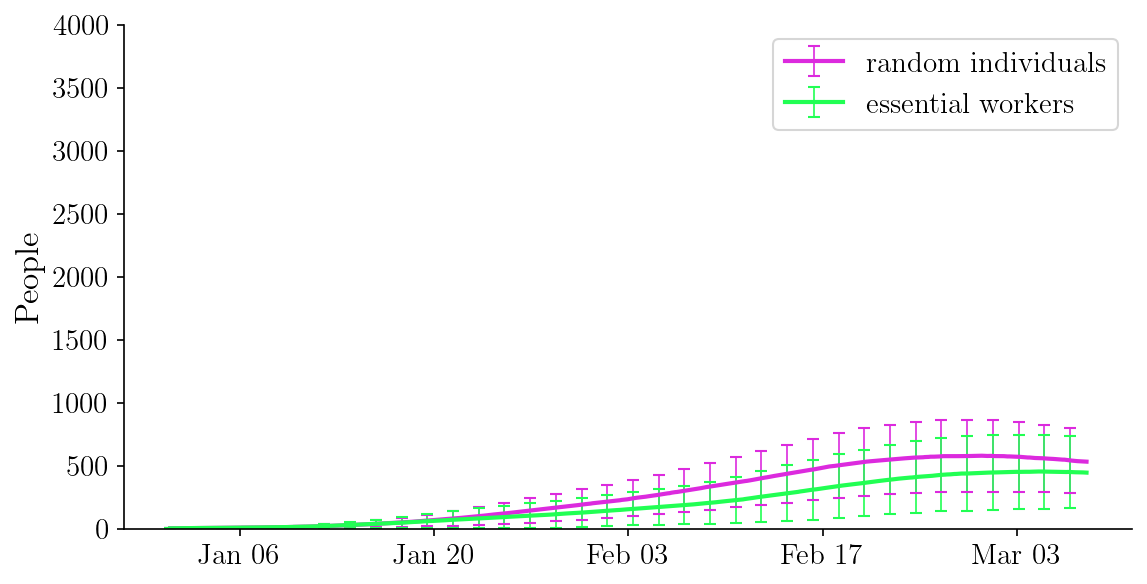

In [10]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 2
# work_site: [13, 30, 18, 14, 21, 0, 35, 16, 17, 26, 25, 22, 12, 15, 23, 4, 20] 17
# number of workers at work site: [141, 117, 151, 99, 141, 128, 135, 120, 127, 135, 124, 114, 120, 140, 124, 151, 110] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 5, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 5, 0.4]
#                                                           edu, office, social, supermarket
# beta household 0, beta else 0.1
# Apr 13 to May 9


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats40_sf_one-comp_essential-type2_prop0.1_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6['basic']
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

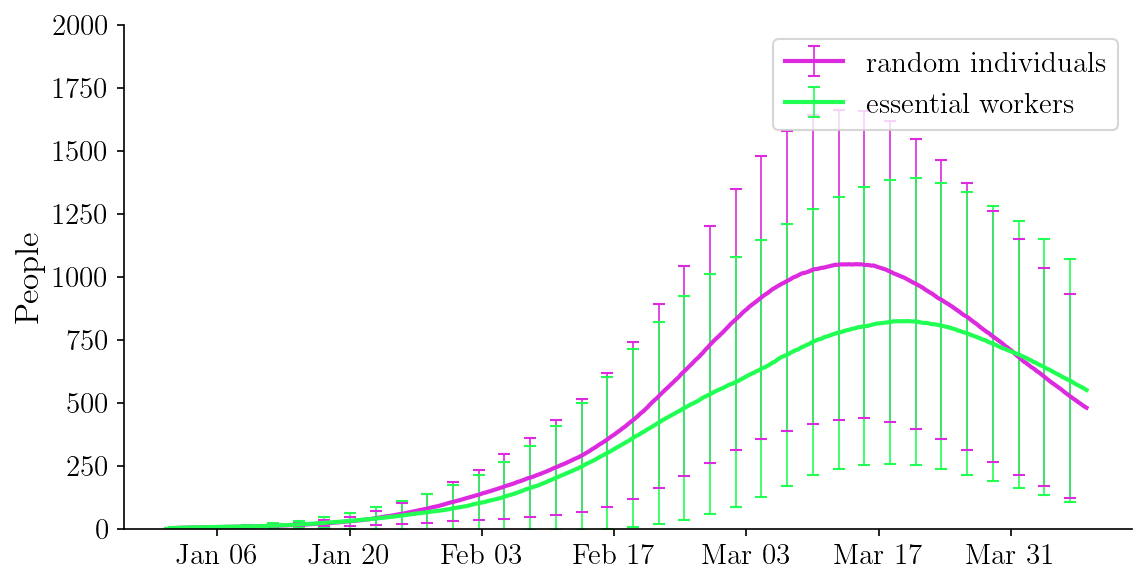

In [2]:
# total population: 8499 , sites: 75
# essential: 859 , non_essential: 7640 , propotion: 0.10107071420167078
# essential proortion per age group: [0.         0.         0.11038961 0.09695817 0.14181597 0.15260323
#  0.03076923 0.        ]
# Population (by Age):  [387, 592, 308, 526, 3293, 1671, 1365, 362] 8504
# Sites by type:  [5, 37, 28, 5]
# essential type: 2
# work_site: [7, 51, 42, 74, 47, 24, 2, 34, 69, 19, 66, 54, 3, 52, 53, 37, 44, 64, 27, 73, 32, 61, 50, 29, 8, 6, 72, 11] 28
# number of workers at work site: [38, 33, 34, 38, 27, 22, 24, 40, 32, 31, 39, 30, 29, 24, 28, 30, 27, 26, 45, 29, 33, 
#                                  37, 30, 20, 32, 18, 29, 34] 859
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 5, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 5, 0.4]
#                                                           edu, office, social, supermarket
# beta household 0, beta else 0.1
# Apr 13 to Jul 9


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats40_sf_one-comp_essential-type2_prop0.1_ds100.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6['basic']
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=2000, errorevery=14)

In [3]:
num_essen = 0
num_non_essen = 0
work_site = []
for i in range(mob.num_people):
    if mob.essential_workers[i]:
        num_essen += 1
        work_site_temp = mob.essential_work_site[i]
        if work_site_temp not in work_site:
            if work_site_temp > -1 :
                work_site.append(work_site_temp)
            #print('essential worker no:',i,' working at site:',mob.essential_work_site[i])
    else:
        num_non_essen += 1

NameError: name 'mob' is not defined

#### Town generator on Local computer

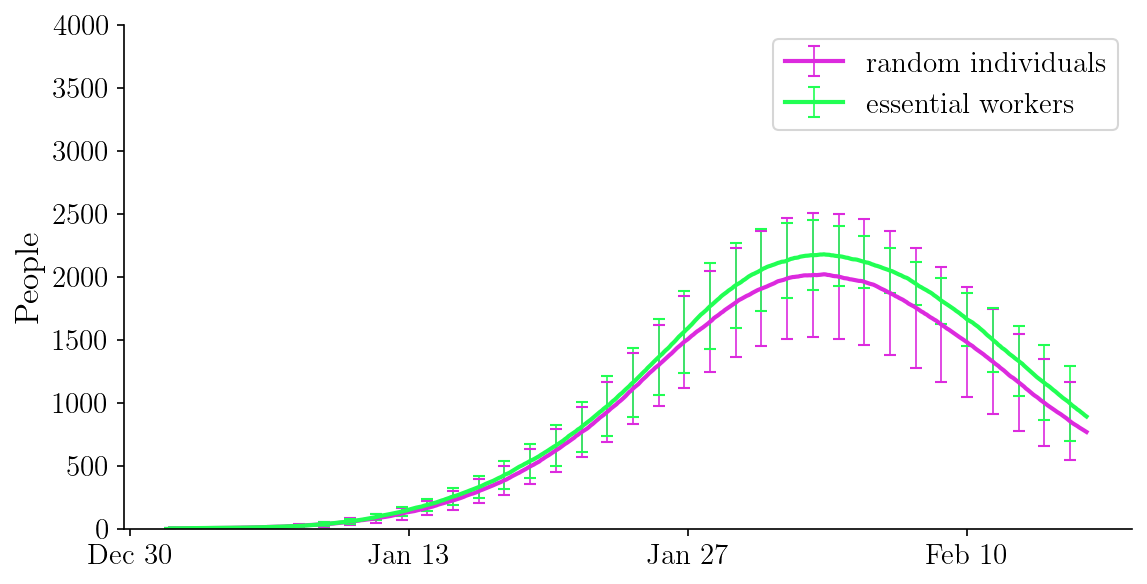

In [3]:
#### Town generator on Local computer
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181] 4251
# Sites by type:  [2, 20, 12, 3]
# essential type: 2
# work_site: [6, 34, 32, 11, 7, 24, 2, 8, 29, 27, 3, 19] 12
# number of workers at work site: [183, 181, 177, 192, 165, 175, 194, 182, 183, 180, 188, 177] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [0.0, 0.0, 5, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [0.0, 0.0, 5, 0.4]
#                                                           edu, office, social, supermarket
# beta household 0, beta else 0.3


summaries_SD_6 = load_summary('sf_comp[0.5]_repeats10_sf_one-comp_essential-type2_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6['basic']
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

## Type 0: edu

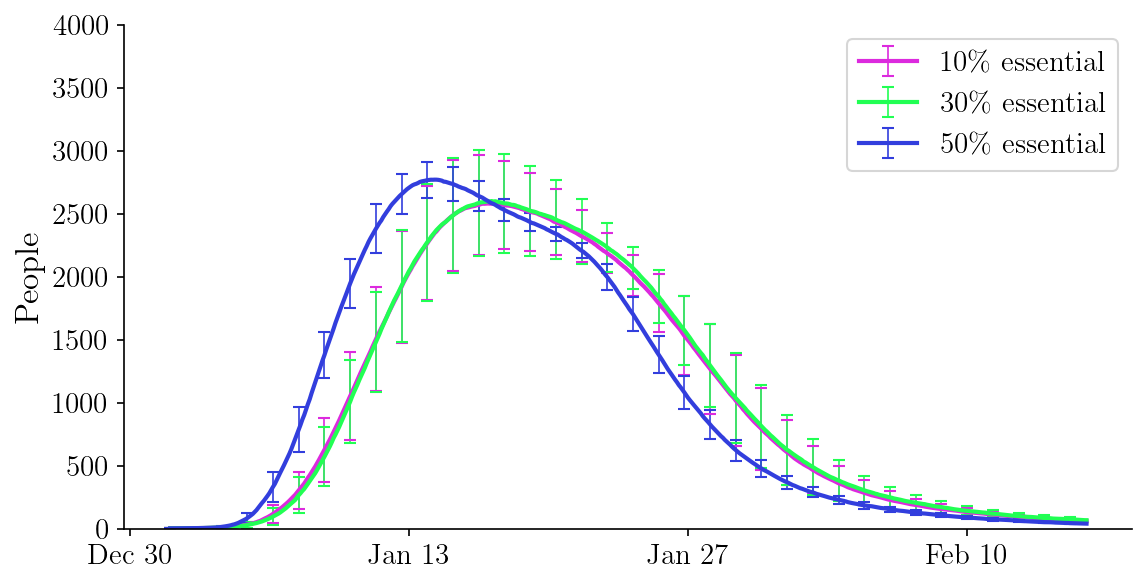

In [51]:
# total population: 4254 , sites: 37
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [28, 9] 2
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [5.0, 0.0, 3.6, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [5.0, 0.0, 0.64, 0.4]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_prop[0.1,0.3,0.5]sf_one-comp_essential-type0_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['10\% essential','30\% essential','50\% essential']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

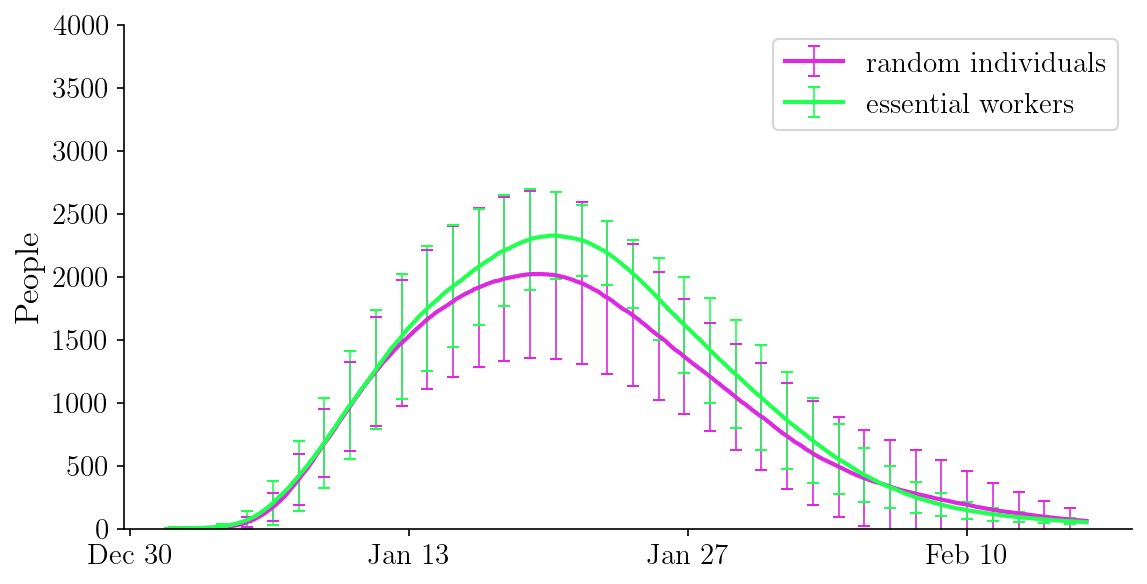

In [2]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [9, 28] 2
# number of workers at work site: [1104, 1073] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [5.0, 0.0, 3.6, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [5.0, 0.0, 0.64, 0.4]
#                                                           edu, office, social, supermarket
# beta household 0, beta else 0.3

summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_sf_one-comp_essential-type0_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6['basic']
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

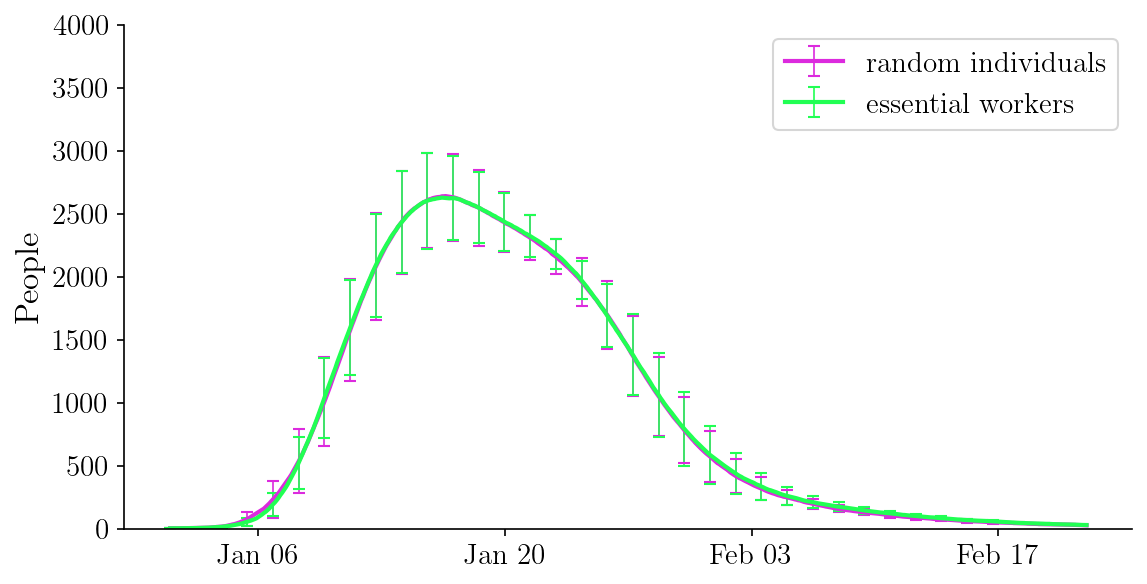

In [44]:
# total population: 4254 , sites: 37
# essential: 430 , non_essential: 3824 , propotion: 0.10108133521391631
# essential proortion per age group: [0.         0.         0.11038961 0.09505703 0.14155529 0.15209581
#  0.03079179 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [28, 9] 2
# number of workers at work site: [215, 215] 430
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [5.0, 0.0, 3.6, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [5.0, 0.0, 0.64, 0.4]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_sf_one-comp_essential-type0_prop0.1_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

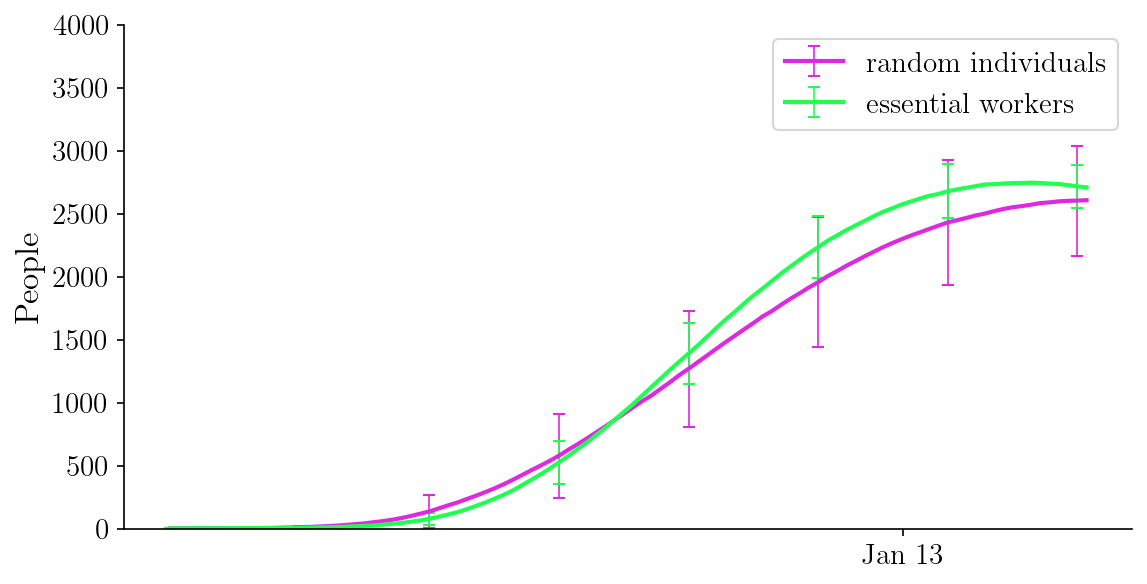

In [27]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [9, 28] 2
# number of workers at work site: [1104, 1073] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [5.0, 0.0, 3.6, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [5.0, 0.0, 0.64, 0.4]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_sf_one-comp_essential-type0_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=100, 
    ymax=4000, errorevery=14)

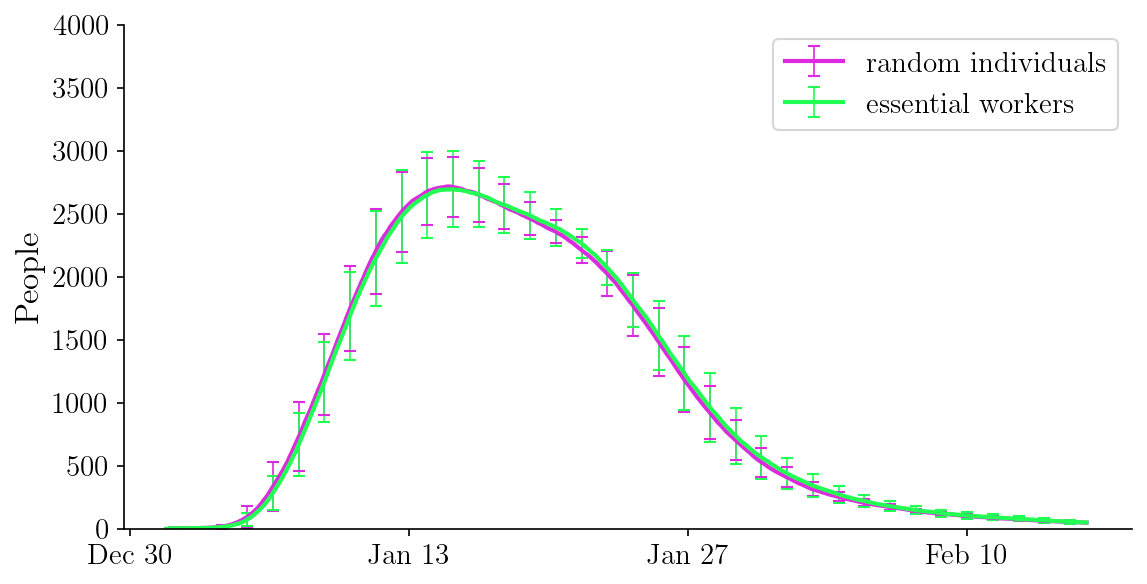

In [67]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [9, 28] 2
# number of workers at work site: [1104, 1073] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [5.0, 0.0, 3.6, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [5.0, 0.0, 0.64, 0.4]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[1.0]_repeats10_sf_one-comp_essential-type0_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['random individuals','essential workers']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

500 range(0, 5)
1104.0
1104.0
1104.0
1104.0
1104.0


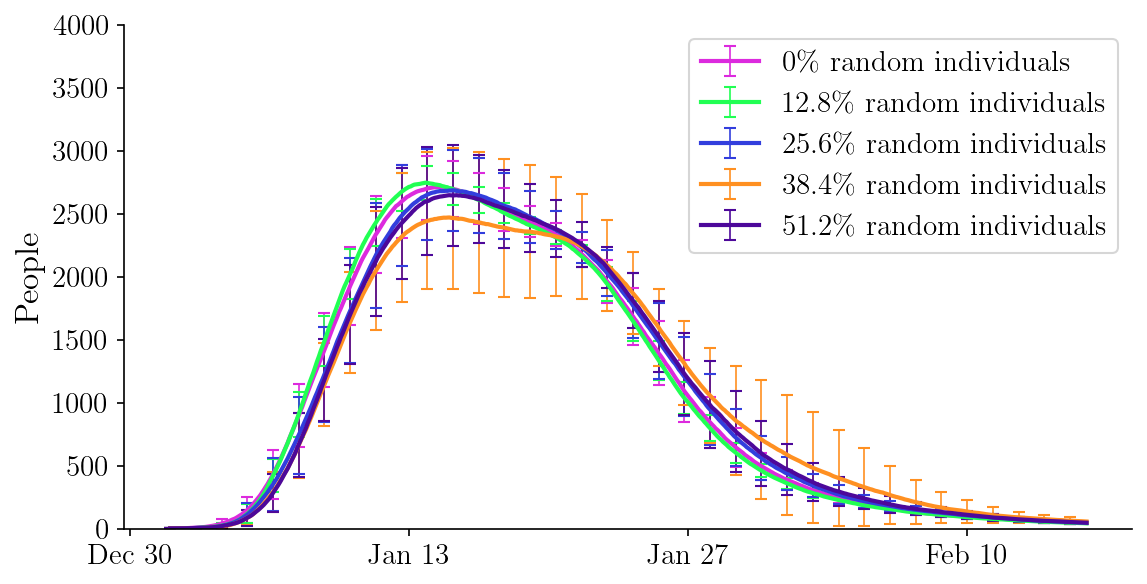

In [66]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [9, 28] 2
# number of workers at work site: [1104, 1073] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [5.0, 0.0, 3.6, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [5.0, 0.0, 0.64, 0.4]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[0.0,0.128,0.256,0.384,0.512]_repeats10_onlyall_sf_one-comp_essential-type0_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['0\% random individuals','12.8\% random individuals','25.6\% random individuals','38.4\% random individuals','51.2\% random individuals']
summaries_ = summaries_SD_6
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)

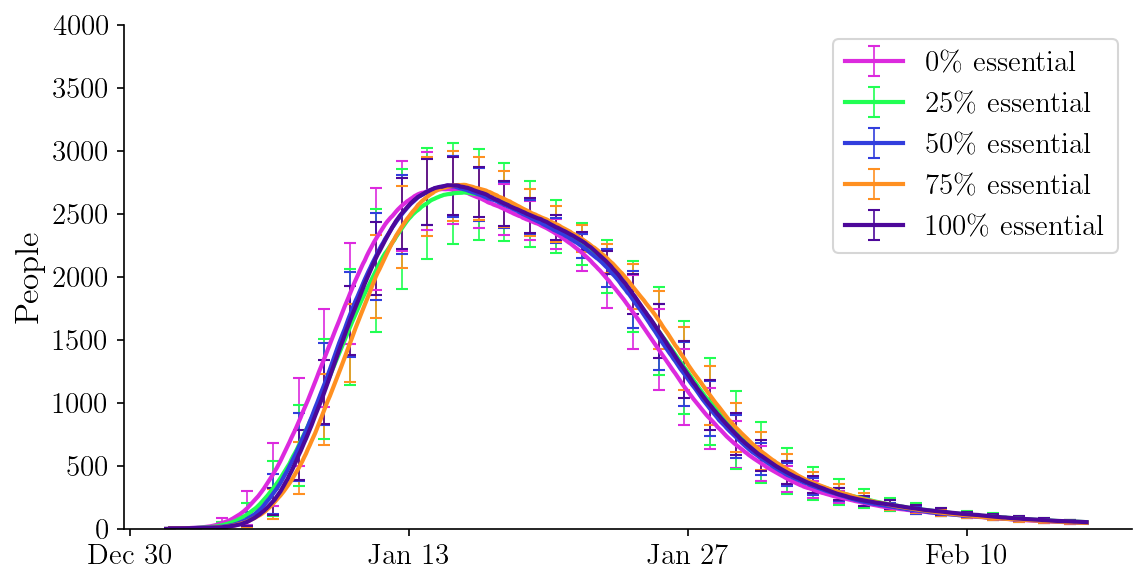

In [77]:
# total population: 4254 , sites: 37
# essential: 2177 , non_essential: 2077 , propotion: 0.5117536436295251
# essential proortion per age group: [0.         0.         0.55194805 0.48288973 0.70959903 0.76287425
#  0.15542522 0.        ]
# Population (by Age):  [194, 296, 154, 263, 1646, 835, 682, 181]
# Sites by type:  [2, 3, 17, 15]
# essential type: 0
# work_site: [9, 28] 2
# number of workers at work site: [1104, 1073] 2177
# regular mob rate: mob_rate_per_age_per_type = [
#       [5,    0,    0,   0],    # 0-14
#       [5,    0,    0,   0],    # 5-14
#       [5,    0,    3.6, 0.22], # 15-19
#       [1.48, 3.52, 3.6, 0.21], # 20-24
#       [0,    5,    3.6, 0.27], # 25-44
#       [0,    5,    3.6, 0.36], # 45-59
#       [0,    0,    3.6, 0.35], # 60-79
#       [0,    0,    3.6, 0.35]] # 80+
# regular dur time: dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
# essential mob rate essential: essential_mob_rate_per_type = [5.0, 0.0, 3.6, 0.27]
# essential dur time essential: essential_dur_mean_per_type = [5.0, 0.0, 0.64, 0.4]
#                                                           edu, office, social, supermarket


summaries_SD_6 = load_summary('sf_comp[0.0,0.25,0.5,0.75,1.0]_repeats10_onlyessen_sf_one-comp_essential-type0_prop0.5_ds200.pk')
FIGSIZE = (8, 4)
plotter = Plotter()
title = ['0\% essential','25\% essential','50\% essential','75\% essential','100\% essential']
summaries_ = summaries_SD_6['basic']
c = 0
runstr = f'run{c}_'

plotter.compare_total_infections(
    summaries_, 
    titles=title, 
    figtitle=r'Total Infections with Contact Tracing Case Isolation for All',
    filename=runstr + 'ST_all', 
    figsize=FIGSIZE, acc=500, 
    ymax=4000, errorevery=14)